In [1]:
#import libraries:

import pandas as pd
import numpy as np
import time
import re
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from pulearn import ElkanotoPuClassifier
from pulearn import BaggingPuClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay

import shap
import warnings
warnings.filterwarnings('ignore')

seed = 42

In [2]:
pd_table = pd.read_csv('BP_GWAS_data.csv')

In [3]:
pd_table

,CP,Gene,diagnosis,star,pathogenicity,DANN.score,CADD.raw_score,CADD.PHRED_score,gerp_scores.N,BETAsbp,...,Skin_Not_Sun_Exposed_Suprapubic,Small_Intestine_Terminal_Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole_Blood,BPlabel
0,10:102075479,PKD2L1,NaN,NaN,NaN,NaN,NaN,NaN,2.510,0.2330,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,10:102552663,PAX2,NaN,NaN,NaN,NaN,NaN,NaN,6.040,0.6868,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,10:102552752,PAX2,NaN,NaN,NaN,NaN,NaN,NaN,6.080,0.6877,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,10:102553647,PAX2,NaN,NaN,NaN,NaN,NaN,NaN,4.120,0.6846,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,10:102554618,PAX2,NaN,NaN,NaN,NaN,1.027054,13.610,3.930,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42777,9:95323297,CENPP,NaN,NaN,NaN,0.440855,0.081993,3.960,2.020,0.1629,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
42778,9:95336327,CENPP,NaN,NaN,NaN,0.446531,-0.035967,2.117,NaN,0.1626,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
42779,9:95337520,CENPP,NaN,NaN,NaN,NaN,NaN,NaN,0.128,-0.1630,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
42780,9:96176203,Y_RNA,NaN,NaN,NaN,0.514746,-0.065587,1.759,NaN,-0.1135,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [4]:
features = pd_table.drop(['Gene', 'CP', 'BPlabel'], axis=1)

In [5]:
#converting labels from True/False to binary numeric values for machine learning
features['BPlabel'] = np.where(pd_table['BPlabel'] == True, 1, 0)
correlated_features = set()
correlation_matrix = features.corr()

In [6]:
#identifying highly correlated features to remove before machine learning
for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [7]:
print(correlated_features)

{'SiPhy_29way_logOdds', 'Kidney_Cortex', 'Spleen', 'Heart_Atrial_Appendage', 'Uterus', 'sift_pred', 'Whole_Blood', 'Vagina', 'Pituitary', 'BETApp', 'Brain_Caudate_basal_ganglia', 'Minor_Salivary_Gland', 'integrated_fitCons', 'Muscle_Skeletal', 'bStatistic', 'Brain_Substantia_nigra', 'Brain_Anterior_cingulate_cortex_BA24', 'CADD.PHRED_score', 'Small_Intestine_Terminal_Ileum'}


In [8]:
#imputing missing features
pd_table['Y'] = np.where(pd_table['BPlabel'] == True, 1, 0)
Y = pd_table['Y']
X = pd_table.drop(['BPlabel', 'Gene', 'CP', 'diagnosis', 'star', 'pathogenicity',
                   'Y'], axis=1)

X.drop(labels=correlated_features, axis=1, inplace=True)
imputer = SimpleImputer(strategy='median', missing_values=np.nan)
X = pd.DataFrame(imputer.fit_transform(X), index=X.index, columns=X.columns)

In [ ]:
#Running positive-unlabelled machine learning with PULearn package
model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)
pu_estimator = BaggingPuClassifier(
    base_estimator=model, n_estimators=15)
pu_estimator.fit(X, Y)

y_pred = pu_estimator.predict_proba(X)

In [ ]:
y_pred = y_pred[:,1]
y_predict = [1 if x > 0.5 else 0 for x in y_pred]
y_positive = Y == 1

print('Classification results:')
acc = accuracy_score(y_positive, y_predict)
print("accuracy: %.2f%%" % (acc * 100.0)) 
f1 = f1_score(y_positive, y_predict)
print("f1: %.2f%%" % (f1 * 100.0)) 
roc = roc_auc_score(y_positive, y_predict)
print("roc: %.2f%%" % (roc * 100.0)) 
rec = recall_score(y_positive, y_predict, average='binary')
print("recall: %.2f%%" % (rec * 100.0)) 
prc = precision_score(y_positive, y_predict, average='binary')
print("precision: %.2f%%" % (prc * 100.0)) 

Classification results:
accuracy: 99.81%
f1: 93.58%
roc: 95.35%
recall: 90.74%
precision: 96.61%


In [ ]:
#Processing model predictions to investigate positive predictions only
X['Y'] = pd_table['Y']
X_pos = X[Y == 1]
X_pos = X_pos.drop(['Y'], axis=1)
X = X.drop(['Y'], axis=1)

In [ ]:
y_pred_pos = pu_estimator.predict_proba(X_pos)
y_pred_pos = y_pred_pos[:,1]
y_predict_pos = [1 if x > 0.5 else 0 for x in y_pred_pos]
y_pos = list(y_positive)

In [ ]:
def estimator_predict(data_asarray):
    data_asframe = pd.DataFrame(data_asarray, columns=X_pos.columns)
    return pu_estimator.predict(data_asframe)

In [ ]:
#Shap interpretation (needing their KernelExplainer so it accepts the PUlearn package)
X_pos_summary = shap.kmeans(X_pos, 10)
ex = shap.KernelExplainer(estimator_predict, X_pos_summary)

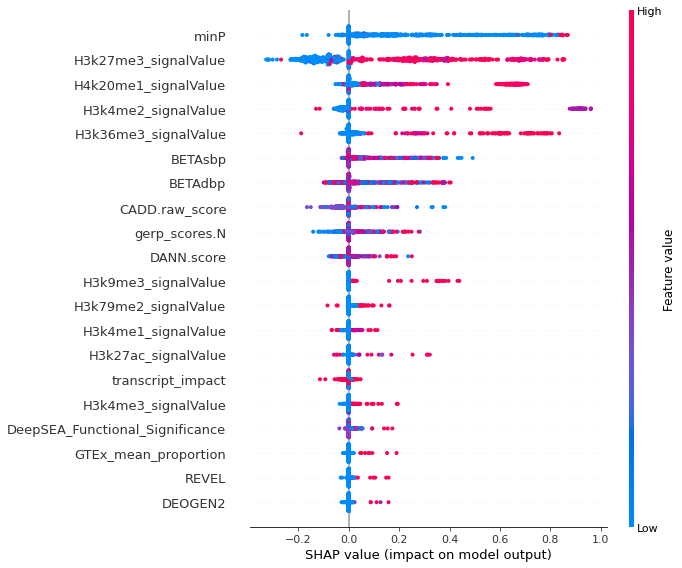

In [15]:
shap_values = ex.shap_values(X_pos)

fig, ax = plt.subplots()
shap.summary_plot(shap_values, X_pos)
fig.savefig('shap_summary_BPlabel.svg', format='svg', dpi=1200, bbox_inches = "tight")

In [16]:
expected_value = ex.expected_value

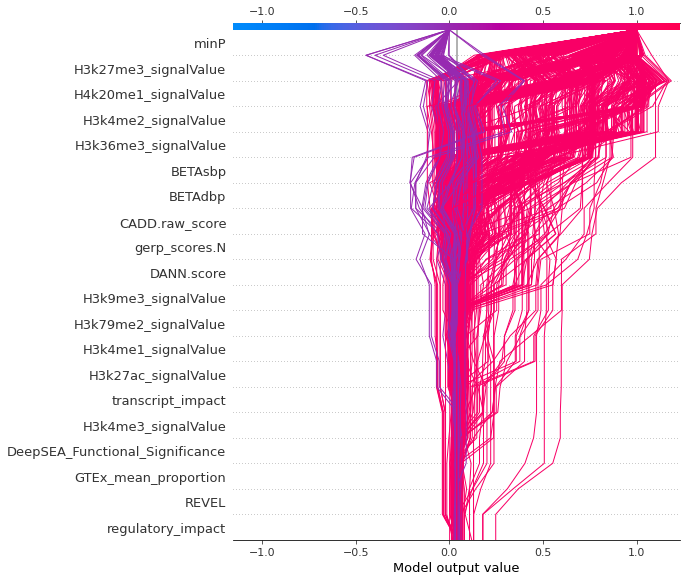

In [17]:
fig, ax = plt.subplots()
shap.decision_plot(
    expected_value,
    ex.shap_values(X_pos),
    list(X_pos),
    ignore_warnings=True,
)
fig.savefig('shap_decisionplot_BPlabel.svg', format='svg', dpi=1200, bbox_inches = "tight")

In [18]:
pd.set_option('display.float_format', str)
y_pred = pu_estimator.predict_proba(X)
y_pred = y_pred[:,1]
output = pd.Series(data=y_pred, name="XGB_Prob")

locus = pd_table[['Gene', 'CP', 'BPlabel']]

df = pd.concat([locus, output], axis=1)
df = df.sort_values(by=['XGB_Prob'], ascending=False)

In [19]:
df.to_csv('XGB_prob_BPlabel.csv', index=False)

In [20]:
df.head(10)

,Gene,CP,BPlabel,XGB_Prob
34989,NPR3,5:32691144,1,0.999004336198171
15293,NEDD4L,18:55720220,1,0.9985892693201701
15296,NEDD4L,18:55720731,1,0.9985840121905009
34990,NPR3,5:32691416,1,0.998579204082489
15294,NEDD4L,18:55720490,1,0.9983976403872172
15278,NEDD4L,18:55714103,1,0.9983026862144471
5621,CCND1,11:69452709,1,0.9981011788050334
30258,CACNA2D2,3:50535915,1,0.9980836749076843
15297,NEDD4L,18:55720915,1,0.9979771415392558
34999,NPR3,5:32694033,1,0.9979271610577901


In [21]:
top = X.iloc[[34989, 15293, 34990, 15296, 34990, 15294, 15278, 5621, 30258, 34999],]

In [22]:
def estimator_predict(data_asarray):
    data_asframe = pd.DataFrame(data_asarray, columns=top.columns)
    return pu_estimator.predict(data_asframe)

X_summary = shap.kmeans(top, 5)
ex = shap.KernelExplainer(estimator_predict, X_summary)

shap_values = ex.shap_values(top)

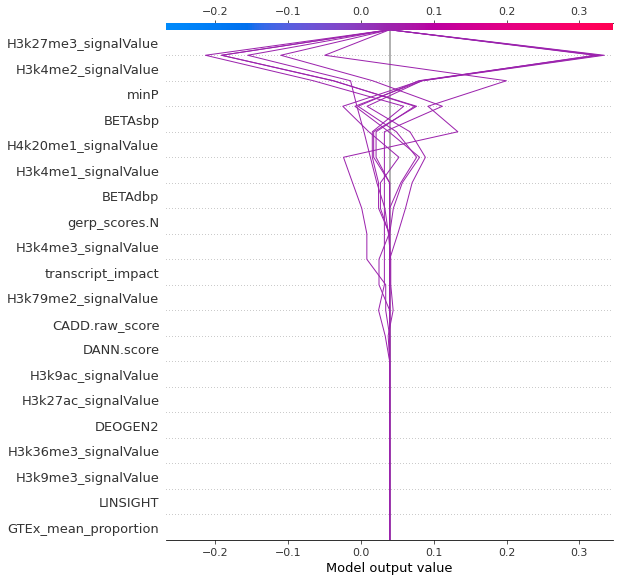

In [23]:
shap.decision_plot(
    expected_value,
    ex.shap_values(top),
    list(top),
    ignore_warnings=True,
)

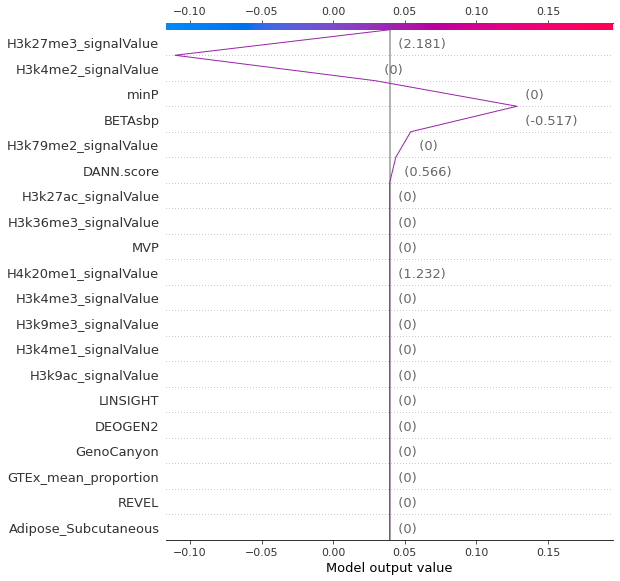

In [24]:
fig, ax = plt.subplots()
shap.decision_plot(
    expected_value,
    ex.shap_values(top.iloc[0]),
    top.iloc[0],
    list(top),
    ignore_warnings=True,
)
fig.savefig('shap_decisionplot_top.svg', format='svg', dpi=1200, bbox_inches = "tight")

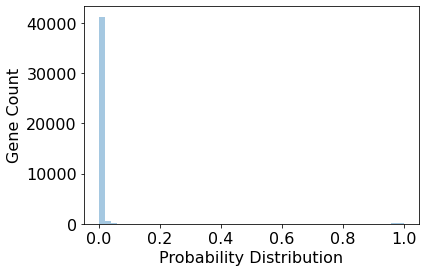

In [25]:
ax = sns.distplot(df["XGB_Prob"], kde=False, norm_hist=False)
ax.set_xlabel("Probability Distribution", fontsize=16)
ax.set_ylabel("Gene Count", fontsize=16)
ax.tick_params(labelsize=16)

In [32]:
#Trying a 'from scratch' approach not using PUlearn package
pd_table['Y'] = np.where(pd_table['BPlabel'] == True, 1, 0)
Y = pd_table['Y']
X = pd_table.drop(['BPlabel', 'Gene', 'CP', 'diagnosis', 'star', 'pathogenicity',
                   ], axis=1)

X.drop(labels=correlated_features, axis=1, inplace=True)
imputer = SimpleImputer(strategy='median', missing_values=np.nan)
X = pd.DataFrame(imputer.fit_transform(X), index=X.index, columns=X.columns)

In [33]:
data_P = X[X.Y == 1]
data_P_test = data_P.sample(frac=0.2)

df_both = data_P.append(data_P_test)
data_P = df_both.drop_duplicates(keep=False)

data_U = X[X.Y == 0]
data_U_test = data_U.sample(207)

df_both = data_U.append(data_U_test)
data_U = df_both.drop_duplicates(keep=False)

df_test = data_P_test.append(data_U_test)

data_P_train = data_P
data_P = data_P.drop(['Y'], axis=1)
data_U = data_U.drop(['Y'], axis=1)

NP = data_P.shape[0]
NU = data_U.shape[0]

In [34]:
T = 1
K = NP
train_label = np.zeros(shape=(NP+K,))
train_label[:NP] = 1.0
n_oob = np.zeros(shape=(NU,))
f_oob = np.zeros(shape=(NU, 2))
start = time.time()
for i in range(T):
    # Bootstrap resample
    bootstrap_sample = np.random.choice(np.arange(NU), replace=True, size=K)
    # Positive set + bootstrapped unlabeled set
    data_bootstrap = np.concatenate((data_P, data_U.iloc[bootstrap_sample, :]), axis=0)
    # Train model
    model = XGBClassifier(objective='binary:logistic', eval_metric='logloss')
    
    model.fit(data_bootstrap, train_label)
    # Index for the out of the bag (oob) samples
    idx_oob = sorted(set(range(NU)) - set(np.unique(bootstrap_sample)))
    # Transductive learning of oob samples
    f_oob[idx_oob] += model.predict_proba(data_U.iloc[idx_oob])
    n_oob[idx_oob] += 1
predict_proba = f_oob[:, 1]/n_oob

end = time.time()
print('Model fitting seconds:', (end - start))

Model fitting seconds: 0.27541518211364746


In [35]:
#Viewing model performance on predicting only positives for all the training data
data_pos = data_P_train
y_pos = data_pos['Y']
data_pos = data_pos.drop(['Y'], axis=1)

y_pred_pos = model.predict_proba(data_pos)
y_pred_pos = y_pred_pos[:,1]
y_predict_pos = [1 if x > 0.5 else 0 for x in y_pred_pos]
y_pos = list(y_pos)

print('XGBoost Classification Results:')
acc = accuracy_score(y_pos, y_predict_pos)
print("Accuracy: %.2f%%" % (acc * 100.0)) 
f1 = f1_score(y_pos, y_predict_pos)
print("F1 Score: %.2f%%" % (f1 * 100.0)) 

XGBoost Classification Results:
Accuracy: 100.00%
F1 Score: 100.00%


In [36]:
#Viewing model performance on predicting only positives for test data 
data_P_test_true = data_P_test.drop(['Y'], axis=1)

y_pos = data_P_test['Y']
y_pos = list(y_pos)

y_pred_pos = model.predict_proba(data_P_test_true)
y_pred_pos = y_pred_pos[:,1]
y_predict_pos = [1 if x > 0.5 else 0 for x in y_pred_pos]


print('XGBoost Classification Results:')
acc = accuracy_score(y_pos, y_predict_pos)
print("Accuracy: %.2f%%" % (acc * 100.0)) 
f1 = f1_score(y_pos, y_predict_pos)
print("F1 Score: %.2f%%" % (f1 * 100.0))

XGBoost Classification Results:
Accuracy: 84.09%
F1 Score: 91.36%


In [37]:
#Viewing model performance on predicting both positive and 'negative' [unlabelled] samples for test data
df_test_true = df_test.drop(['Y'], axis=1)

y_true = df_test['Y']

y_pred_pos = model.predict_proba(df_test_true)
y_pred_pos = y_pred_pos[:,1]
y_predict_pos = [1 if x > 0.5 else 0 for x in y_pred_pos]


print('XGBoost Classification Results:')
acc = accuracy_score(y_true, y_predict_pos)
print("Accuracy: %.2f%%" % (acc * 100.0)) 
f1 = f1_score(y_true, y_predict_pos)
print("F1 Score: %.2f%%" % (f1 * 100.0))

XGBoost Classification Results:
Accuracy: 86.43%
F1 Score: 82.84%


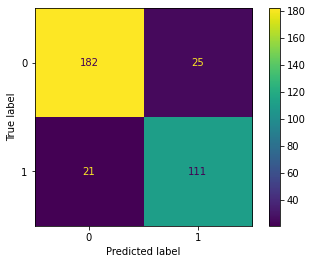

In [38]:
cm = confusion_matrix(y_true, y_predict_pos)

cm_display = ConfusionMatrixDisplay(cm).plot()

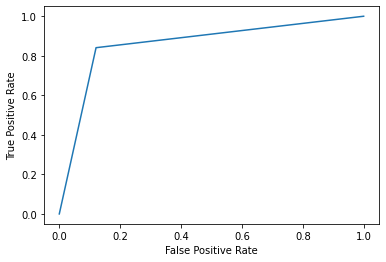

In [39]:
fpr, tpr, _ = roc_curve(y_true, y_predict_pos, pos_label=model.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

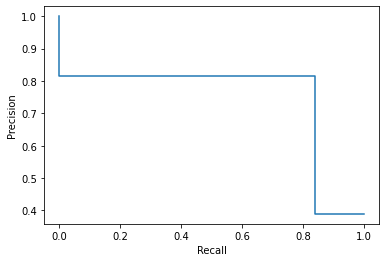

In [40]:
prec, recall, _ = precision_recall_curve(y_true, y_predict_pos, pos_label=model.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

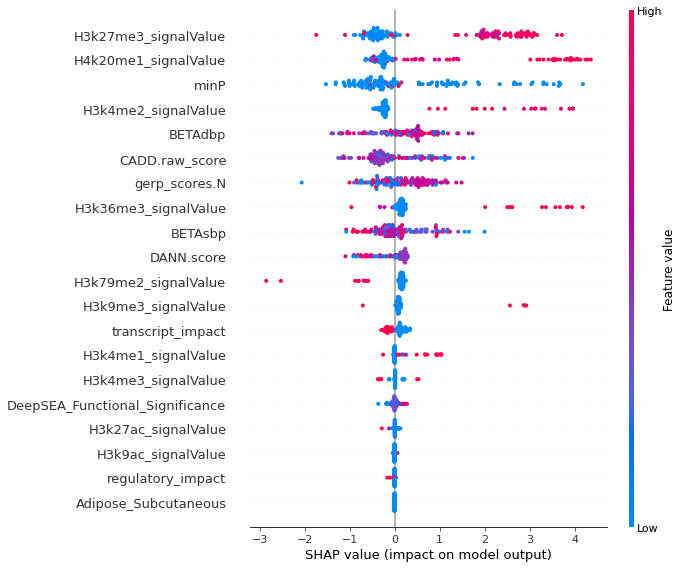

In [41]:
explainer = shap.TreeExplainer(model) 
shap_values = explainer.shap_values(data_P_test_true) 
shap.summary_plot(shap_values, data_P_test_true) 

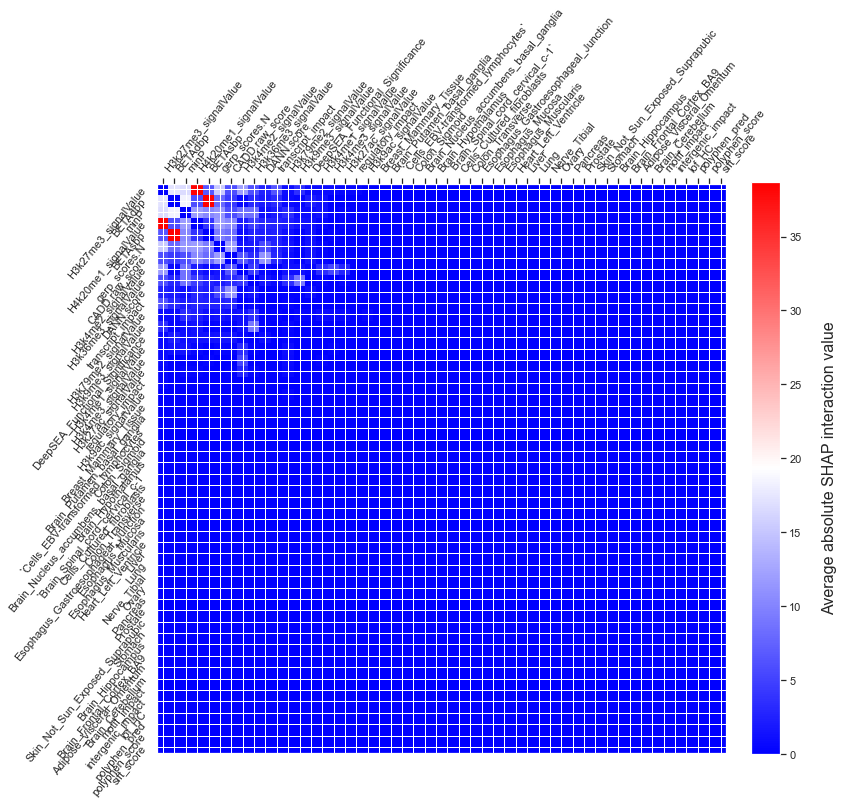

In [44]:
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(data_P_test_true)

expected_value = explainer.expected_value

tmp = np.abs(shap_interaction_values).sum(0)
for i in range(tmp.shape[0]):
    tmp[i, i] = 0
inds = np.argsort(-tmp.sum(0))[:50]
tmp2 = tmp[inds, :][:, inds]

sns.set(font_scale = 1)
f = plt.figure(figsize=(12, 12))
plt.imshow(
    tmp2, cmap="bwr"
)  # https://matplotlib.org/stable/gallery/color/colormap_reference.html
plt.yticks(
    range(tmp2.shape[0]),
    data_P_test_true.columns[inds],
    rotation=50.4,
    horizontalalignment="right",
)
plt.xticks(
    range(tmp2.shape[0]),
    data_P_test_true.columns[inds],
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label("Average absolute SHAP interaction value", size=16, labelpad=20)
plt.rcParams.update({"font.size": 16})
plt.tight_layout()

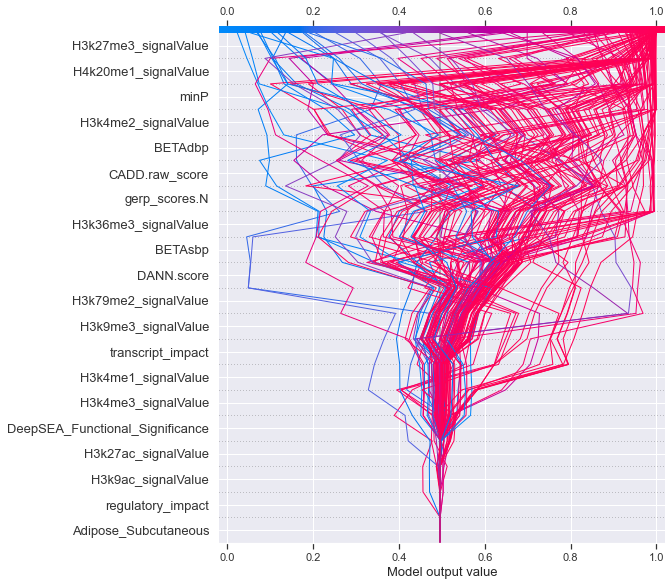

In [46]:
shap.decision_plot(expected_value, shap_values, list(data_P_test_true), link='logit')